In [1]:
import numpy as np
import os
from source.helpers import matprint
from source.DLD_Matcher_QUBO import (
    calc_time_sum,
    generate_event_u1_u2_MCP,
    generate_double_u1_u2_MCP,
    get_QUBO_matrix,
    solve_qubo_bruteforce,
)

In [2]:
def test_DLD_QUBO(n: int = 10, time_sum=120.0):
    g = np.random.default_rng(42)
    pred = []
    true = []
    vals = []
    for _ in range(n):
        e12 = generate_double_u1_u2_MCP(
            time_sum=time_sum,
            bin_max=255,
            binsize=0.8,
            noise_std=0.0,
            g=g,
        )  # shape (3, 2)
        # randomly permute second dimension. perms = [0/1, 0/1, 0/1]
        # if 1, swap
        perms = g.integers(0, 2, size=3)
        for i in range(3):
            if perms[i] == 1:
                e12[i] = e12[i, ::-1]

        Q = get_QUBO_matrix(e12[0], e12[1], e12[2], time_sum)
        s = solve_qubo_bruteforce(Q, 1)[0]
        pred.append(s[0])
        vals.append(s[1])
        true.append(perms)
    return np.array(true), np.array(pred), np.array(vals)


def check_correct(y, ypred):
    """
    y: binary array
    ypred: binary array

    check if all entries are the same or if all are the same if y is flipped (all entries)
    """
    out = np.all(y == ypred)
    out_flipped = np.all(y == 1 - ypred)

    return out or out_flipped


if __name__ == "__main__":
    g = np.random.default_rng(44)
    time_sum = 120.0

    print("-" * 50, "\nTesting double event generation")
    e12 = generate_double_u1_u2_MCP(
        time_sum=time_sum,
        bin_max=255,
        binsize=0.8,
        noise_std=1.0,
        g=g,
    )
    print(f"event peaks positions: [channel u1/u2/MCP, electron 1/2]\n {e12}")
    ts_1 = calc_time_sum(e12[0, 0], e12[1, 0], e12[2, 0])
    ts_2 = calc_time_sum(e12[0, 1], e12[1, 1], e12[2, 1])
    print(f"time sums electron 1: {ts_1}")
    print(f"time sums electron 2: {ts_2}")

    print("\n", "-" * 50, "\nTesting QUBO formulation with generated event")
    Q = get_QUBO_matrix(e12[0], e12[1], e12[2], time_sum)
    print("QUBO matrix Q =")
    matprint(Q)
    print()
    sols = solve_qubo_bruteforce(Q, 8)
    for s in sols:
        print(f"solution: {s[0]}, energy: {s[1]}")
    q = sols[0][0]
    print(f"For {q=}")
    print(f"{q.T @ Q @ q=}")

    print("\n", "-" * 50, "\nTesting QUBO formulation with many events")
    true, pred, vals = test_DLD_QUBO(50)
    for t, p, v in zip(true, pred, vals):
        print(f"true: {t}, pred: {p}, energy: {v:10.4}, correct: {check_correct(t, p)}")


-------------------------------------------------- 
Testing double event generation
event peaks positions: [channel u1/u2/MCP, electron 1/2]
 [[ 65.81883407  41.39086682]
 [103.42717337 121.91733758]
 [ 24.45962733  21.36462395]]
time sums electron 1: 120.32675277776409
time sums electron 2: 120.57895651044484

 -------------------------------------------------- 
Testing QUBO formulation with generated event
QUBO matrix Q =
 1205.77  -903.354  -302.419  
-903.354   674.446   228.908  
-302.419   228.908   73.5101  

solution: [1 1 1], energy: -5.826450433232822e-13
solution: [0 0 0], energy: 0.0
solution: [1 1 0], energy: 73.5100818794674
solution: [0 0 1], energy: 73.51008187946813
solution: [0 1 0], energy: 674.4457684841318
solution: [1 0 1], energy: 674.4457684841319
solution: [0 1 1], energy: 1205.7728166582283
solution: [1 0 0], energy: 1205.7728166582283
For q=array([1, 1, 1])
q.T @ Q @ q=-5.826450433232822e-13

 -------------------------------------------------- 
Testing QUBO f

Now with rounding of QUBO matrix

In [5]:
import os
import sys
# os.chdir("..") # want to import from this directories source folder
from source.DLD_Matcher_QUBO import scale_and_round_qubo
sys.path.append("../source")

from qubo import solve_qubo_bruteforce, plot_distribution, anneal, draw_solutions, evaluate_mapping, get_Q_from_coords, get_register_embedding
from qubovert_custom import problem_to_qubo_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm

100%|██████████| 1000/1000 [00:02<00:00, 484.67it/s]


mean loss: 0.17625862008816837


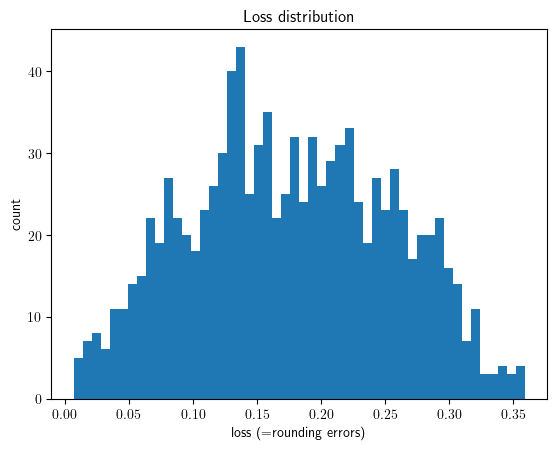

In [8]:
g = np.random.default_rng(42)
time_sum = 120.0
n = 1000
max_abs_value = 50

losses = []
for i in tqdm(range(n)):
    e12 = generate_double_u1_u2_MCP(
        time_sum=time_sum,
        bin_max=255,
        binsize=0.8,
        noise_std=1.0,
        g=g,
    )
    Q = get_QUBO_matrix(e12[0], e12[1], e12[2], time_sum)
    scaled_Q, scale, props = scale_and_round_qubo(
        Q, max_abs_value=max_abs_value, max_scale_multiplier=500
    )
    # matprint(scaled_Q)
    losses.append(props["loss"])

mean_loss = np.mean(losses)
print(f"mean loss: {mean_loss}")
plt.hist(losses, bins=50)
plt.ylabel("count")
plt.xlabel("loss (=rounding errors)")
plt.title("Loss distribution")
plt.show()


In [83]:
def evaluate_qubo_rounding(n:int, time_sum:float, max_abs_value:float, g=None, verbose:bool = True):
    if g is None:
        g = np.random.default_rng(42)
    true = []
    pred = []
    pred_second = []
    for i in tqdm(range(n), disable=not verbose):
        e12 = generate_double_u1_u2_MCP(
            time_sum=time_sum,
            bin_max=255,
            binsize=0.8,
            noise_std=1.0,
            g=g,
        )
        perms = g.integers(0, 2, size=3)
        for i in range(3):
            if perms[i] == 1:
                e12[i] = e12[i, ::-1]

        Q = get_QUBO_matrix(e12[0], e12[1], e12[2], time_sum)
        scaled_Q, scale, props = scale_and_round_qubo(
            Q, max_abs_value=max_abs_value, max_scale_multiplier=500
        )
        sols = solve_qubo_bruteforce(scaled_Q, 2)
        s = sols[0]
        s_second = sols[1]
        true.append(perms)
        pred.append(s[0])
        pred_second.append(s_second[0])

    true = np.array(true)
    pred = np.array(pred)
    pred_second = np.array(pred_second)
    correct = np.array([check_correct(t, p) for t, p in zip(true, pred)])
    correct_second = np.array([check_correct(t, p) for t, p in zip(true, pred_second)])

    if verbose:
        for t, p, c in zip(true, pred, correct_second):
            print(f"true: {t}, pred: {p}, correct: {c}, second: {c}")

        print(f"correct: {np.sum(correct)}/{len(correct)}")
    return true, pred, correct, correct_second

In [81]:
time_sum = 120.0
n = 10
max_abs_value = 50

evaluate_qubo_rounding(n, time_sum, max_abs_value)

100%|██████████| 10/10 [00:00<00:00, 456.86it/sTrue]

true: [1 1 1], pred: [0 0 0], correct: False, second: False
true: [1 1 0], pred: [0 0 1], correct: True, second: True
true: [1 1 0], pred: [0 0 1], correct: True, second: True
true: [1 0 0], pred: [0 1 1], correct: True, second: True
true: [1 1 0], pred: [0 0 0], correct: True, second: True
true: [1 1 0], pred: [0 0 0], correct: True, second: True
true: [0 0 1], pred: [0 0 1], correct: True, second: True
true: [1 0 0], pred: [0 1 1], correct: True, second: True
true: [1 1 1], pred: [0 0 0], correct: True, second: True
true: [0 0 1], pred: [0 0 1], correct: True, second: True
correct: 8/10


(array([[1, 1, 1],
        [1, 1, 0],
        [1, 1, 0],
        [1, 0, 0],
        [1, 1, 0],
        [1, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [1, 1, 1],
        [0, 0, 1]]),
 array([[0, 0, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 1],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 1],
        [0, 1, 1],
        [0, 0, 0],
        [0, 0, 1]]),
 array([ True,  True,  True,  True, False, False,  True,  True,  True,
         True]),
 array([False,  True,  True,  True,  True,  True,  True,  True,  True,
         True]))

max_abs_val:     10, correct: 67/100=0.6700
max_abs_val:     15, correct: 70/100=0.7000
max_abs_val:     20, correct: 77/100=0.7700
max_abs_val:     25, correct: 83/100=0.8300
max_abs_val:     30, correct: 84/100=0.8400
max_abs_val:     35, correct: 84/100=0.8400
max_abs_val:     40, correct: 85/100=0.8500
max_abs_val:     45, correct: 87/100=0.8700
max_abs_val:     50, correct: 85/100=0.8500
max_abs_val:     60, correct: 86/100=0.8600
max_abs_val:     70, correct: 88/100=0.8800
max_abs_val:     80, correct: 90/100=0.9000
max_abs_val:     90, correct: 89/100=0.8900
max_abs_val:    100, correct: 89/100=0.8900
max_abs_val:    150, correct: 94/100=0.9400
max_abs_val:    200, correct: 93/100=0.9300
max_abs_val:    300, correct: 93/100=0.9300
max_abs_val:    400, correct: 94/100=0.9400


Text(0.5, 1.0, 'Percentage for Q_scaled_rounded same ground state as Q')

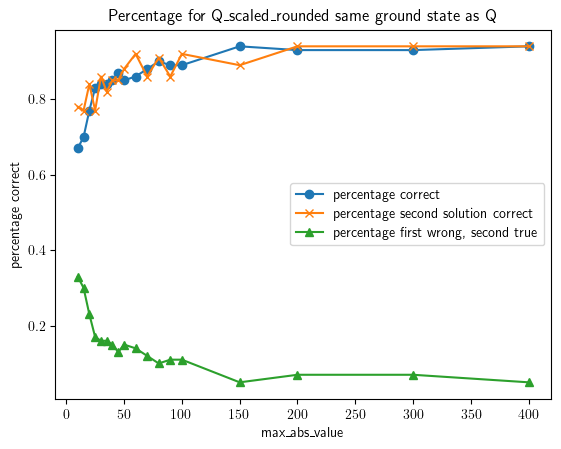

In [84]:
n = 100
max_abs_vals = [10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 150, 200, 300, 400]
percentages = []
percentages_second = []
first_wrong_second_true_percentage = []
first_or_second_true = []
for max_abs_value in max_abs_vals:
    true, pred, correct, correct_second = evaluate_qubo_rounding(n, time_sum, max_abs_value, verbose=False)
    percentage = np.sum(correct) / len(correct)
    percentate_second = np.sum(correct_second) / len(correct_second)
    percentages.append(percentage)
    percentages_second.append(percentate_second)
    first_wrong_second_true_percentage.append(
        np.sum(np.logical_and(correct == False, correct_second == True)) / len(correct_second)
    )
    first_or_second_true.append(
        np.sum(np.logical_or(correct == True, correct_second == True)) / len(correct_second)
    )
    print(f"max_abs_val: {max_abs_value:6}, correct: {np.sum(correct)}/{len(correct)}={percentage:.4f}")
percentages = np.array(percentages)
percentages_second = np.array(percentages_second)
first_wrong_second_true_percentage = np.array(first_wrong_second_true_percentage)
first_or_second_true = np.array(first_or_second_true)

plt.plot(max_abs_vals, percentages, marker="o")
plt.plot(max_abs_vals, percentages_second, marker="x")
plt.plot(max_abs_vals, first_wrong_second_true_percentage, marker="^")
plt.legend(["percentage correct", "percentage second solution correct", "percentage first wrong, second true"])
plt.xlabel("max_abs_value")
plt.ylabel("percentage correct")
plt.title("Percentage for Q_scaled_rounded same ground state as Q")

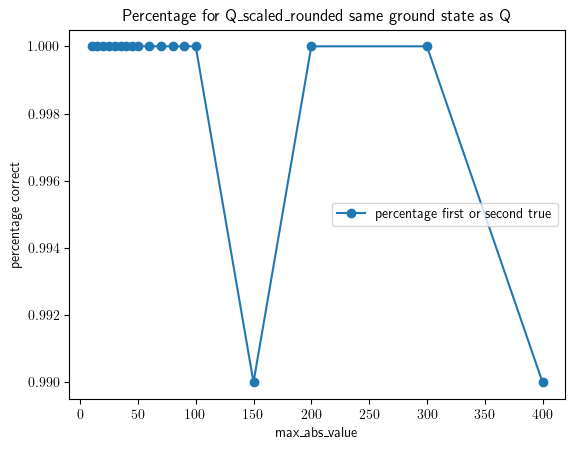

In [79]:
plt.plot(max_abs_vals, first_or_second_true, marker="o")
plt.xlabel("max_abs_value")
plt.ylabel("percentage correct")
plt.title("Percentage for Q_scaled_rounded same ground state as Q")
plt.legend(["percentage first or second true"])
plt.show()